In [4]:
import glob
import rasterio
import numpy as np
from rasterio.windows import from_bounds
from pyproj import Transformer
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

we'll have NYC, London, Tokyo, Sao Paulo, Delhi, Shanghai, Mexico City, Cairo, Paris and LA, shoutout chatgpt for providing the list and coordinates

In [5]:
import os

# Disable keyring and private file check early to avoid Windows SID lookup errors
os.environ['PYTHON_KEYRING_BACKEND'] = 'keyring.backends.null.Keyring'
os.environ['OPENEO_NO_PRIVATE_FILE_CHECK'] = '1'

import openeo
from datetime import date

# Connect to Copernicus openEO backend
conn = openeo.connect("https://openeo.dataspace.copernicus.eu")
conn.authenticate_oidc()

# Sentinel-2 metropolitan center points (lon, lat)
cities = {
    "new_york": (-74.0060, 40.7127),
    "london": (-0.1257, 51.5074),
    "tokyo": (139.6917, 35.6895),
    "sao_paulo": (-46.6339, -23.5503),
    "delhi": (77.2167, 28.6083),
    "shanghai": (121.4737, 31.2304),
    "mexico_city": (-99.1332, 19.4319),
    "cairo": (31.2497, 30.0626),
    "paris": (2.3522, 48.8566),
    "los_angeles": (-118.2435, 34.0522),
}

# Area size (10 km x 10 km)
BOX_HALF_SIZE = 0.05  # ~5 km

for city, (lon, lat) in cities.items():
    bbox = {
        "west": lon - BOX_HALF_SIZE,
        "south": lat - BOX_HALF_SIZE,
        "east": lon + BOX_HALF_SIZE,
        "north": lat + BOX_HALF_SIZE,
        "crs": "EPSG:4326"
    }

    print(f"Processing {city}...")

    cube = conn.load_collection(
        "SENTINEL2_L2A",
        spatial_extent=bbox,
        temporal_extent=["2024-01-01", "2025-11-30"],
        bands=["B04", "B03", "B02"],
        properties={
            "eo:cloud_cover": lambda x: x <= 10
        }
    )

    # Reduce time dimension: select lowest cloud cover image
    cube = cube.reduce_dimension(
    dimension="t",
    reducer="first"
)


    # Save as GeoTIFF
    cube.download(
        format="GTiff",
        outputfile=f"C:\\Users\\kacpe\\Desktop\\Studia\\ML\\cities\\{city}_Sentinel_2_RGB.tif"
    )

print("All downloads completed.")


Authenticated using refresh token.
Processing new_york...
Processing london...
Processing tokyo...
Processing sao_paulo...


Failed to parse API error response: [502] 'Bad Gateway' (headers: {'Date': 'Sun, 25 Jan 2026 22:07:03 GMT', 'Content-Length': '11'})
Preflight process graph validation failed: [502] Bad Gateway


Processing delhi...
Processing shanghai...
Processing mexico_city...
Processing cairo...
Processing paris...
Processing los_angeles...
All downloads completed.


now make a json that will help use all those files

In [10]:
import os, json

def tif_bbox_center_single(tif_path, to_crs="EPSG:4326"):

    with rasterio.open(tif_path) as src:
        bounds = src.bounds  # left, bottom, right, top
        src_crs = src.crs

        # center in native CRS
        cx = (bounds.left + bounds.right) / 2
        cy = (bounds.bottom + bounds.top) / 2

        if to_crs is not None and str(src_crs) != to_crs:
            transformer = Transformer.from_crs(src_crs, to_crs, always_xy=True)
            west, south = transformer.transform(bounds.left, bounds.bottom)
            east, north = transformer.transform(bounds.right, bounds.top)
            lon_c, lat_c = transformer.transform(cx, cy)
            out_crs = to_crs
        else:
            west, south, east, north = bounds.left, bounds.bottom, bounds.right, bounds.top
            lon_c, lat_c = cx, cy
            out_crs = str(src_crs)

    bbox = {"west": west, "south": south, "east": east, "north": north, "crs": out_crs}
    center = {"lat": lat_c, "lon": lon_c}
    return bbox, center


def export_tifs_bbox_center_to_json(pattern, out_json, to_crs="EPSG:4326"):
    files = sorted(glob.glob(pattern))
    results = {}

    for fp in files:
        base = os.path.basename(fp)
        name_no_ext = os.path.splitext(base)[0]           # e.g., new_york_S2_L2A_RGB
        city_key = name_no_ext.split('_')[0]              # e.g., new_york
        bbox, center = tif_bbox_center_single(fp, to_crs)
        results[city_key] = {
            "file": fp,
            "bbox": bbox,
            "center": center
        }

    os.makedirs(os.path.dirname(out_json), exist_ok=True)
    with open(out_json, 'w', encoding='utf-8') as f:
        json.dump(results, f, indent=2, ensure_ascii=False)

    return out_json, len(files)


# Example usage (adjust paths if needed):
pattern = r"C:\\Users\\kacpe\\Desktop\\Studia\\ML\\cities\\*_Sentinel_2_RGB.tif"
out_json = r"C:\\Users\\kacpe\\Desktop\\Studia\\ML\\cities\\cities_bound_box_center.json"
export_tifs_bbox_center_to_json(pattern, out_json)

('C:\\\\Users\\\\kacpe\\\\Desktop\\\\Studia\\\\ML\\\\cities\\\\cities_bound_box_center.json',
 10)

while we're at it, lets get some forests too

In [ ]:
import openeo
from datetime import date

# Connect to Copernicus openEO backend
conn = openeo.connect("https://openeo.dataspace.copernicus.eu")
conn.authenticate_oidc()

# Sentinel-2 forests center points (lon, lat)
forests = {
    # Tropical rainforests
    "amazon_central": (-62.0, -3.0),             # Central Amazon Basin (Brazil)
    "congo_basin": (18.0, -1.0),                 # Congo Rainforest (DRC)
    "bornean_rainforest": (114.0, 1.0),          # Borneo (Malaysia/Indonesia) - this one did not have good data, skipping
    "sumatra_rainforest": (101.0, -0.5),         # Sumatra (Indonesia)
    "new_guinea_rainforest": (143.0, -5.5),      # Papua New Guinea

    # Temperate & boreal forests
    "taiga_central_siberia": (100.0, 62.0),       # Siberian Taiga
    "canadian_boreal": (-105.0, 56.0),            # Canadian Boreal Forest
    "valdivian_temperate": (-72.0, -40.0),        # Valdivian Temperate Rainforest (Chile)
    "european_birch_forest": (14.0, 48.0),        # Central European forest
    "tongass_forest": (-134.0, 57.5),             # Tongass National Forest (Alaska)
}

# Rainforests and other forests as they look different from satelites

# Area size (10 km x 10 km)
BOX_HALF_SIZE = 0.05  # ~5 km

for forest, (lon, lat) in forests.items():
    bbox = {
        "west": lon - BOX_HALF_SIZE,
        "south": lat - BOX_HALF_SIZE,
        "east": lon + BOX_HALF_SIZE,
        "north": lat + BOX_HALF_SIZE,
        "crs": "EPSG:4326"
    }

    print(f"Processing {forest}...")
    cube = conn.load_collection(
        "SENTINEL2_L2A",
        spatial_extent=bbox,
        temporal_extent=["2022-01-01", "2025-11-30"],
        bands=["B04", "B03", "B02"],
        properties={
            "eo:cloud_cover": lambda x: x <= 10
        }
    )

    # Reduce time dimension: select lowest cloud cover image
    cube = cube.reduce_dimension(
    dimension="t",
    reducer="first"
)


    # Save as GeoTIFF
    cube.download(
        format="GTiff",
        outputfile=f"C:\\Users\\kacpe\\Desktop\\Studia\\ML\\forests\\{forest}_Sentinel_2_RGB.tif"
    )



Authenticated using refresh token.
Processing amazon_central...
Processing congo_basin...
Processing bornean_rainforest...
Processing sumatra_rainforest...
Processing new_guinea_rainforest...
Processing taiga_central_siberia...
Processing canadian_boreal...
Processing valdivian_temperate...
Processing european_beech_forest...
Processing tongass_forest...
All downloads completed.


In [8]:
import os, json

def tif_bbox_center_single(tif_path, to_crs="EPSG:4326"):

    with rasterio.open(tif_path) as src:
        bounds = src.bounds  # left, bottom, right, top
        src_crs = src.crs

        # center in native CRS
        cx = (bounds.left + bounds.right) / 2
        cy = (bounds.bottom + bounds.top) / 2

        if to_crs is not None and str(src_crs) != to_crs:
            transformer = Transformer.from_crs(src_crs, to_crs, always_xy=True)
            west, south = transformer.transform(bounds.left, bounds.bottom)
            east, north = transformer.transform(bounds.right, bounds.top)
            lon_c, lat_c = transformer.transform(cx, cy)
            out_crs = to_crs
        else:
            west, south, east, north = bounds.left, bounds.bottom, bounds.right, bounds.top
            lon_c, lat_c = cx, cy
            out_crs = str(src_crs)

    bbox = {"west": west, "south": south, "east": east, "north": north, "crs": out_crs}
    center = {"lat": lat_c, "lon": lon_c}
    return bbox, center


def export_tifs_bbox_center_to_json(pattern, out_json, to_crs="EPSG:4326"):
    files = sorted(glob.glob(pattern))
    results = {}

    for fp in files:
        base = os.path.basename(fp)
        name_no_ext = os.path.splitext(base)[0]           # e.g., new_york_S2_L2A_RGB
        city_key = name_no_ext.split('_')[0]              # e.g., new_york
        bbox, center = tif_bbox_center_single(fp, to_crs)
        results[city_key] = {
            "file": fp,
            "bbox": bbox,
            "center": center
        }

    os.makedirs(os.path.dirname(out_json), exist_ok=True)
    with open(out_json, 'w', encoding='utf-8') as f:
        json.dump(results, f, indent=2, ensure_ascii=False)

    return out_json, len(files)


# Example usage (adjust paths if needed):
pattern = r"C:\\Users\\kacpe\\Desktop\\Studia\\ML\\forests\\*_Sentinel_2_RGB.tif"
out_json = r"C:\\Users\\kacpe\\Desktop\\Studia\\ML\\forests\\forests_bound_box_center.json"
export_tifs_bbox_center_to_json(pattern, out_json)

('C:\\\\Users\\\\kacpe\\\\Desktop\\\\Studia\\\\ML\\\\forests\\\\forests_bound_box_center.json',
 10)

Urban metadata sample:
  cairo: {'lat': 30.062571104425526, 'lon': 31.249695334967914}
  delhi: {'lat': 28.608316225295233, 'lon': 77.216752959243}
  london: {'lat': 51.50740357334219, 'lon': -0.12565561721674692}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0013429308122045551..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.05334258863733447..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.061183243508084274..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.022757039947609692..1.0].


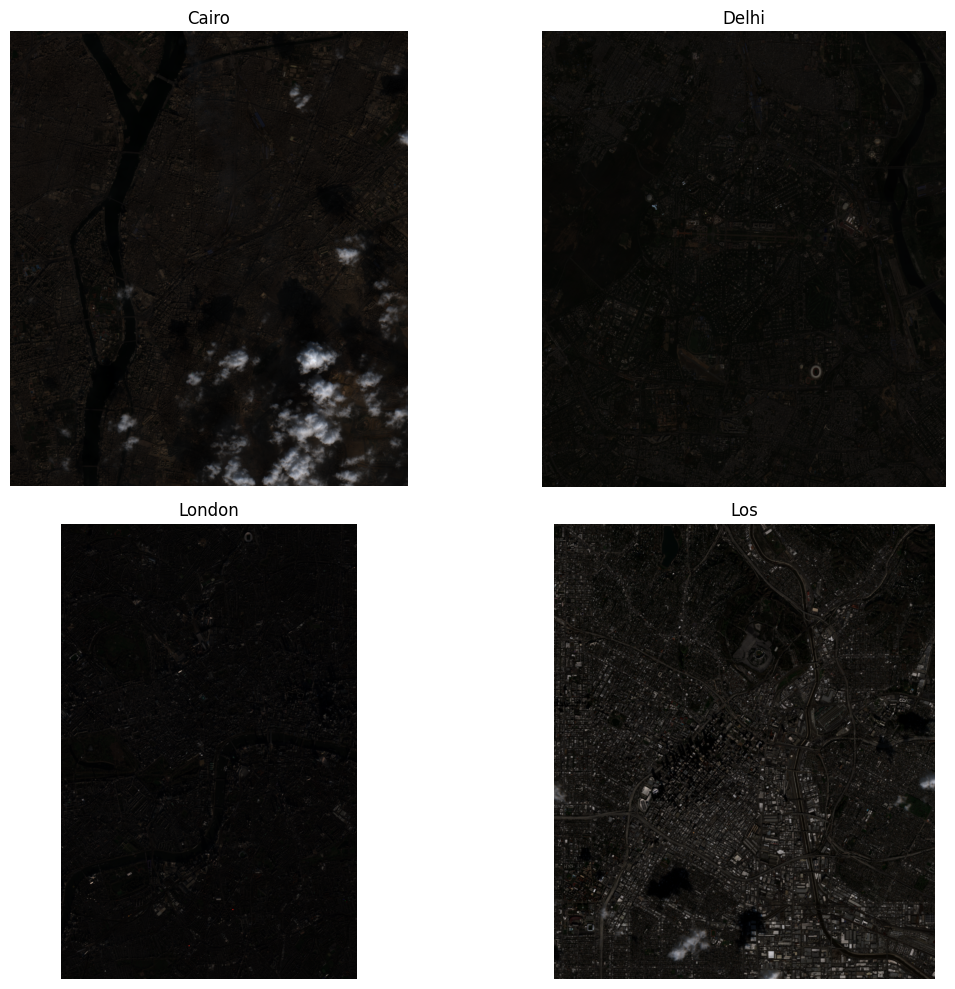


Urban TIF info:
  cairo: shape=(1124, 982), dtype=int16, crs=EPSG:32636
  delhi: shape=(1128, 1000), dtype=int16, crs=EPSG:32643
  london: shape=(1140, 739), dtype=int16, crs=EPSG:32630
  los: shape=(1121, 938), dtype=int16, crs=EPSG:32611


In [9]:
# Quality control - visualize downloaded urban TIFFs
import json

# Load metadata
with open(r"C:\\Users\\kacpe\\Desktop\\Studia\\ML\\cities\\cities_bound_box_center.json") as f:
    urban_metadata = json.load(f)

# Show first few entries
print("Urban metadata sample:")
for city in list(urban_metadata.keys())[:3]:
    print(f"  {city}: {urban_metadata[city]['center']}")

# Load and display a few urban TIFFs
cities_to_show = list(urban_metadata.keys())[:4]
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
axs = axs.flatten()

for idx, city in enumerate(cities_to_show):
    tif_path = urban_metadata[city]['file']
    with rasterio.open(tif_path) as src:
        # Read RGB bands (B04=R, B03=G, B02=B)
        rgb = src.read([1, 2, 3])
        rgb = np.transpose(rgb, (1, 2, 0))
        
        # Normalize for display (0-1 range)
        rgb = rgb / rgb.max()
        
        axs[idx].imshow(rgb)
        axs[idx].set_title(f"{city.replace('_', ' ').title()}")
        axs[idx].axis('off')

plt.tight_layout()
plt.show()

# Show file info
print("\nUrban TIF info:")
for city in cities_to_show:
    tif_path = urban_metadata[city]['file']
    with rasterio.open(tif_path) as src:
        print(f"  {city}: shape={src.shape}, dtype={src.dtypes[0]}, crs={src.crs}")